# VAE Version (AI Lab Run)
- V2: inheriting from A-V10, that we have attention module, as well as biLSTM. Now we also add VAE. 

## Preparing

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_sequence
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from model_model import LBiR_LBiRInit as TheLearner
from model_dataset import DS_Tools
from model_dataset import WordDataset as ThisDataset
from model_dataset import Normalizer, DeNormalizer, TokenMap
# from model_dataset import MelSpecTransformDB as TheTransform
from model_dataset import MelSpecTransformDB as TheTransform
from paths import *
from misc_my_utils import *
from misc_recorder import *
from model_loss import *
from model_padding import generate_mask_from_lengths_mat

### Dirs

In [ ]:
rec_dir = train_cut_word_
train_guide_path = os.path.join(src_, "guide_train.csv")
valid_guide_path = os.path.join(src_, "guide_validation.csv")
test_guide_path = os.path.join(src_, "guide_test.csv")

### Constants

In [ ]:
BATCH_SIZE = 512

INPUT_DIM = 64
OUTPUT_DIM = 64 

INTER_DIM_0 = 32
INTER_DIM_1 = 16
INTER_DIM_2 = 8

ENC_SIZE_LIST = [INPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]
DEC_SIZE_LIST = [OUTPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]

DROPOUT = 0.5

REC_SAMPLE_RATE = 16000
N_FFT = 400
N_MELS = 64

LOADER_WORKER = 32
# LOADER_WORKER = 0

## Prepare for this time of training

In [ ]:
ts = str(get_timestamp())
ts = "0206003946"
stop_epoch = "29"
train_name = "B_02"
model_save_dir = os.path.join(model_save_, f"{train_name}-{ts}")
mk(model_save_dir)
print(f"{train_name}-{ts}")

train_losses = ListRecorder(os.path.join(model_save_dir, "train.loss"))
valid_losses = ListRecorder(os.path.join(model_save_dir, "valid.loss"))

train_kl_losses = ListRecorder(os.path.join(model_save_dir, "train.kl.loss"))
valid_kl_losses = ListRecorder(os.path.join(model_save_dir, "valid.kl.loss"))

train_accs = ListRecorder(os.path.join(model_save_dir, "train.acc"))
valid_accs = ListRecorder(os.path.join(model_save_dir, "valid.acc"))
text_hist = HistRecorder(os.path.join(model_save_dir, "trainhist.txt"))

A_05-0206003946


In [ ]:
READ = False
DATAREAD = False

In [ ]:
with open(os.path.join(src_, "no-stress-seg.dict"), "rb") as file:
    # Load the object from the file
    mylist = pickle.load(file)
    mylist = ["BLANK"] + mylist

# Now you can use the loaded object
mymap = TokenMap(mylist)

mytrans = TheTransform(sample_rate=REC_SAMPLE_RATE, 
                       n_fft=N_FFT, n_mels=N_MELS, 
                       normalizer=Normalizer.norm_mvn, 
                       denormalizer=DeNormalizer.norm_mvn)

train_ds = ThisDataset(rec_dir, 
                       train_guide_path, 
                       mapper=mymap, 
                       transform=mytrans)
valid_ds = ThisDataset(rec_dir, 
                       valid_guide_path, 
                       mapper=mymap, 
                       transform=mytrans)

use_proportion = 0.3

if READ or DATAREAD: 
    train_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "train.use"))
    valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "valid.use"))

    use_train_ds = torch.utils.data.Subset(train_ds, train_ds_indices)
    use_valid_ds = torch.utils.data.Subset(valid_ds, valid_ds_indices)
else: 
    # train data
    use_len = int(use_proportion * len(train_ds))
    remain_len = len(train_ds) - use_len
    use_train_ds, remain_ds = random_split(train_ds, [use_len, remain_len])

    # valid data
    use_len = int(use_proportion * len(valid_ds))
    remain_len = len(valid_ds) - use_len
    use_valid_ds, remain_ds = random_split(valid_ds, [use_len, remain_len])

    # NOTE: we don't need to save the cut-small subset, because after cutting-small, 
    # the saved train and valid separations will reflect this
    DS_Tools.save_indices(os.path.join(model_save_dir, "train.use"), use_train_ds.indices)
    DS_Tools.save_indices(os.path.join(model_save_dir, "valid.use"), use_valid_ds.indices)

train_loader = DataLoader(use_train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
train_num = len(train_loader.dataset)

valid_loader = DataLoader(use_valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
valid_num = len(valid_loader.dataset)

In [ ]:
train_num, valid_num, len(train_loader), len(valid_loader)

In [ ]:
# Load sample data from train_loader
sample_data = next(iter(valid_loader))
masked_xx_pad, masked_xx_lens, xx_pad, x_lens = sample_data
print(xx_pad.shape)
# Set the random seed for reproducibility
# random.seed(101)
# Generate six random indices
# random_indices = random.sample(range(len(xx_pad)), 6)
random_indices = list(range(6, 9))

# Plot the spectrograms and mark the corresponding seg
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    spectrogram = xx_pad[idx]
    
    ax = axes[i]
    img = ax.imshow(spectrogram.T, aspect='auto', origin="lower")
    ax.set_title(f'Spectrogram')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')

for i, idx in enumerate(random_indices):
    spectrogram = masked_xx_pad[idx]
    
    ax = axes[i + 3]
    img = ax.imshow(spectrogram.T, aspect='auto', origin="lower")
    ax.set_title(f'Spectrogram')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.colorbar(img,ax=axes)
plt.show()

## VAE
CNN在MNIST上有过于明显的优势, 我们只采用纯DNN来做Auto Encoder.

随手搞一个网络结构出来就行:

- 输入层维度: input_dim = 784.
- 过渡层维度: inter_dim = 256.
- 隐变量维度: latent_dim = 2, 方便后续可视化.

In [6]:
latent_dim = 2
input_dim = 28 * 28
inter_dim = 256

class VAE(nn.Module):
    def __init__(self, input_dim=input_dim, inter_dim=inter_dim, latent_dim=latent_dim):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, inter_dim),
            nn.ReLU(),
            nn.Linear(inter_dim, latent_dim * 2),
        )

        self.decoder =  nn.Sequential(
            nn.Linear(latent_dim, inter_dim),
            nn.ReLU(),
            nn.Linear(inter_dim, input_dim),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        epsilon = torch.randn_like(mu)
        return mu + epsilon * torch.exp(logvar / 2)

    def forward(self, x):
        org_size = x.size()
        batch = org_size[0]
        x = x.view(batch, -1)

        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=1)
        z = self.reparameterise(mu, logvar)
        recon_x = self.decoder(z).view(size=org_size)

        return recon_x, mu, logvar

说一点细节:

- Encoder和Decoder用nn.Sequential的形式写, 方便后续直接使用decoder.
- $p(Z\mid X_k)$的均值$\mu$和方差$\sigma^2$的形式上可以拆成两个小的DNN得出, 这里用一个DNN得出, 然后通过torch.chunk函数将均值和方差分开, 实际上是和前者等价的.
- Encoder末尾千万别像网上某些例子在再接一个ReLU. 在优化过程中, 我们的隐变量$Z$是要逐渐趋向于$\mathcal{N}(0, I)$的, 如果非要加个ReLU的话, 本身假设的隐变量维度就很小, 小于0的隐变量直接就没了… Decoder在解码时直接就会因为信息不足而崩掉.
- 我们在这里拟合的是$\log \sigma^2$而不是$\sigma^2$, 所以重参数方差的表示法是torch.exp(logvar / 2).



## Loss
VAE的损失由重构损失和KL损失组成.

KL散度就不再推导了, 直接放结果:
$$KL\Big(N(\mu,\sigma^2)\Big\Vert N(0,1)\Big)=\frac{1}{2}\Big(-\log \sigma^2+\mu^2+\sigma^2-1\Big)$$

VAE的目标是最小化$Z$和$\mathcal{N}(0, I)$之间的KL散度, 代码只需要照着写就行了:

In [7]:
kl_loss = lambda mu, logvar: -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
recon_loss = lambda recon_x, x: F.binary_cross_entropy(recon_x, x, size_average=False)

因为MNIST是黑白二值图像, 所以的Decoder就可以用Sigmoid后的值当做灰度, 重构损失直接就用BCE了, 用MSE做重构损失尚可. 但如果是三通道图像或者是灰度图像, 还是必须使用MSE做重构损失.

## Training
先定义好训练的epoch和batch_size, 优化器随便选一个世界上最好的优化器Adam(lr=1e-3):

In [8]:
epochs = 100
batch_size = 128

transform = transforms.Compose([transforms.ToTensor()])
data_train = MNIST('MNIST_DATA/', train=True, download=True, transform=transform)
data_valid = MNIST('MNIST_DATA/', train=False, download=True, transform=transform)

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(data_valid, batch_size=batch_size, shuffle=False, num_workers=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VAE(input_dim, inter_dim, latent_dim)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

训练的代码就不详细说了, 和一般的训练过程并无二异, 每次测试时最好把损失的两项都打印出来观察一下:

In [9]:
best_loss = 1e9
best_epoch = 0

valid_losses = []
train_losses = []

for epoch in range(epochs):
    print(f"Epoch {epoch}")
    model.train()
    train_loss = 0.
    train_num = len(train_loader.dataset)

    for idx, (x, _) in enumerate(train_loader):
        batch = x.size(0)
        x = x.to(device)
        recon_x, mu, logvar = model(x)
        recon = recon_loss(recon_x, x)
        kl = kl_loss(mu, logvar)

        loss = recon + kl
        train_loss += loss.item()
        loss = loss / batch

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if idx % 100 == 0:
            print(f"Training loss {loss: .3f} \t Recon {recon / batch: .3f} \t KL {kl / batch: .3f} in Step {idx}")

    train_losses.append(train_loss / train_num)

    valid_loss = 0.
    valid_recon = 0.
    valid_kl = 0.
    valid_num = len(test_loader.dataset)
    model.eval()
    with torch.no_grad():
        for idx, (x, _) in enumerate(test_loader):
            x = x.to(device)
            recon_x, mu, logvar = model(x)
            recon = recon_loss(recon_x, x)
            kl = kl_loss(mu, logvar)
            loss = recon + kl
            valid_loss += loss.item()
            valid_kl += kl.item()
            valid_recon += recon.item()

        valid_losses.append(valid_loss / valid_num)

        print(f"Valid loss {valid_loss / valid_num: .3f} \t Recon {valid_recon / valid_num: .3f} \t KL {valid_kl / valid_num: .3f} in epoch {epoch}")

        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch

            torch.save(model.state_dict(), 'best_model_mnist')
            print("Model saved")

Epoch 0


/home/franklhtan/anaconda3/envs/wavln/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Training loss  551.769 	 Recon  551.761 	 KL  0.008 in Step 0
Training loss  205.866 	 Recon  199.009 	 KL  6.857 in Step 100
Training loss  184.175 	 Recon  177.795 	 KL  6.380 in Step 200
Training loss  183.905 	 Recon  178.157 	 KL  5.748 in Step 300
Training loss  177.614 	 Recon  172.275 	 KL  5.338 in Step 400
Valid loss  174.002 	 Recon  168.542 	 KL  5.461 in epoch 0
Model saved
Epoch 1
Training loss  171.015 	 Recon  165.581 	 KL  5.434 in Step 0
Training loss  173.654 	 Recon  168.312 	 KL  5.342 in Step 100
Training loss  168.016 	 Recon  162.658 	 KL  5.358 in Step 200
Training loss  163.998 	 Recon  158.438 	 KL  5.560 in Step 300
Training loss  161.425 	 Recon  156.133 	 KL  5.292 in Step 400
Valid loss  166.532 	 Recon  161.111 	 KL  5.421 in epoch 1
Model saved
Epoch 2
Training loss  166.593 	 Recon  161.080 	 KL  5.514 in Step 0
Training loss  168.021 	 Recon  162.718 	 KL  5.303 in Step 100
Training loss  164.817 	 Recon  159.371 	 KL  5.446 in Step 200
Training loss 

觉得Loss位数保留太多的可以自己设置.

下面画出训练过程中训练集和验证集上的损失曲线:

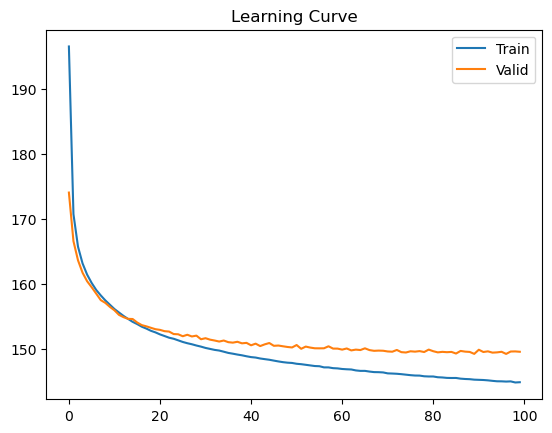

In [10]:
plt.plot(train_losses, label='Train')
plt.plot(valid_losses, label='Valid')
plt.legend()
plt.title('Learning Curve')

基本上Valid Loss稳定了(其实还有下降空间). 同时要保存在验证集上结果最好的模型, 因为等会还要用最好的模型做生成.

## Visualization
再导俩包:

In [11]:
import numpy as np
from scipy.stats import norm

norm可以在隐变量的区域内按照正态分布采样.

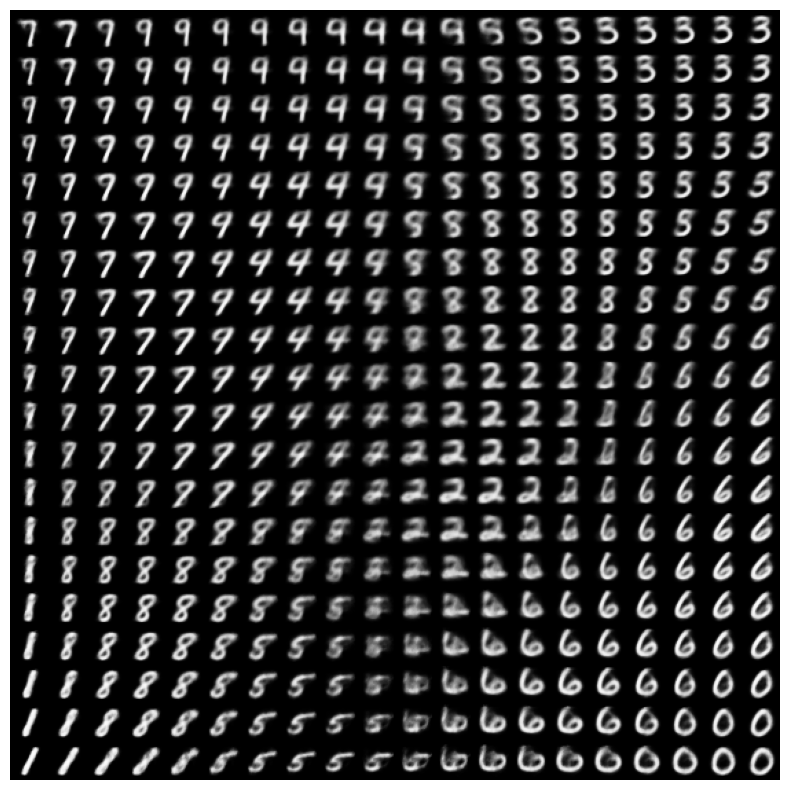

In [12]:
state = torch.load('best_model_mnist')
model = VAE()
model.load_state_dict(state)


n = 20
digit_size = 28

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))


model.eval()
figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        t = [xi, yi]
        z_sampled = torch.FloatTensor(t)
        with torch.no_grad():
            decode = model.decoder(z_sampled)
            digit = decode.view((digit_size, digit_size))
            figure[
                i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size
            ] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap="Greys_r")
plt.xticks([])
plt.yticks([])
plt.axis('off');

对于MNIST这样简单的数据集, 隐变量的某些区域已经能完成生成任务. 并且可以从图中观察到随着隐变量的变化对生成结果产生的影响.

从图中能够很明确的看到手写数字种类的过渡, 例如长的比较像的1, 9, 7, 都带圆弧的8, 3, 5, 再到6, 0. 但是VAE生成的内容有点点糊, 在MNSIT上影响不大, 但扩展到三通道数据时, 这个问题会变得更为显著.

# Pokemon!
每个人都想做从零开始的宝可梦训练大师! 在李宏毅老师的课程中层提到过用VAE生成神奇宝贝的事情. 下面就来尝试下. 数据集下载点我, 原始数据大小为(3, 40, 40). 本节代码没有放到Colab上, 与在MNIST上的过程大同小异, 感兴趣可以自己尝试.

这次的VAE就该用CNN了, DNN有点力不从心.

下述代码不做过多的解读, 结果也不是太好, 大家就当看个乐子.

导包: